In [9]:
import pandas as pd

## Practice

In [10]:
# Read in the practice sheet in experiment.xlsx into a pandas df
df = pd.read_excel("experiment.xlsx", sheet_name="practice") 

# Make sure that item and no are integers
df['exp'] = pd.to_numeric(df['exp'], errors='coerce').astype('Int64')
df['item'] = pd.to_numeric(df['item'], errors='coerce').astype('Int64')
df['no'] = pd.to_numeric(df['no'], errors='coerce').astype('Int64')

# Drop rows where 'item' is empty or not an integer
df = df[pd.to_numeric(df["item"], errors="coerce").notna()]

# Drop these columns: image_pair_left	image_pair_right	vpx	definite	uncountable	remark
df = df.drop(columns=['image_pair_left', 'image_pair_right', 'vpx', 'definite', 'uncountable', 'remark'], errors='ignore')

# If 'cb' column is 'y', then switch the values of the left and right column.
df.loc[df['cb'] == 'y', ['left', 'right']] = df.loc[df['cb'] == 'y', ['right', 'left']].values

# Randomize the order of the rows in a reproducible way
# df = df.sample(frac=1, random_state=1349).reset_index(drop=True)

# Reset index
df = df.reset_index(drop=True)

# Save to CSV
csv_file = "practice.csv"
df.to_csv(csv_file, index=False)

print(f"Filtered data saved to {csv_file}!")
df


Filtered data saved to practice.csv!


,no,item,exp,condition,group,cb,r1,r2,r3,r4,r5,r6,r7,left,right,question,target
0,990,900,<NA>,practice,NaN,n,Ez,"egy példamondat,",kérlek,válaszd,majd,az A betűs,képet.,A,B,NaN,A
1,991,901,<NA>,practice,NaN,y,Ez is,"csak gyakorlás,",kérlek,majd,válaszd,a C betűs,képet.,D,C,NaN,C
2,992,902,<NA>,practice,NaN,n,Itt,pedig,válaszd,azt a képet,amelyik,balodalt,van.,E,F,Melyik van a bal oldalon?,E


## Live Experiment

In [11]:
# Read in experiment.xlsx into a pandas df
import pandas as pd

df = pd.read_excel("experiment.xlsx")

# Make sure that item and no are integers
df['exp'] = pd.to_numeric(df['exp'], errors='coerce').astype('Int64')
df['item'] = pd.to_numeric(df['item'], errors='coerce').astype('Int64')
df['no'] = pd.to_numeric(df['no'], errors='coerce').astype('Int64')

# Drop rows where 'item' is empty or not an integer
df = df[pd.to_numeric(df["item"], errors="coerce").notna()]

# Drop these columns: image_pair_left	image_pair_right	vpx	definite	uncountable	remark
df = df.drop(columns=['image_pair_left', 'image_pair_right', 'vpx', 'definite', 'uncountable', 'remark'], errors='ignore')

# If 'cb' column is 'y', then switch the values of the left and right column.
df.loc[df['cb'] == 'y', ['left', 'right']] = df.loc[df['cb'] == 'y', ['right', 'left']].values

In [12]:
# Randomize the order of the rows in a reproducible way
# df = df.sample(frac=1, random_state=1349).reset_index(drop=True)

# Ensure no two consecutive rows have the same value in the 'condition' column.
import heapq
import random

def shuffle_no_adjacent(df, col='condition', random_state=42, max_fallback_attempts=200):
    rng = random.Random(random_state)

    # Build groups of row indices per condition
    groups = {}
    for idx, cond in df[col].astype(str).items():
        groups.setdefault(cond, []).append(idx)

    # Shuffle within each condition for randomness
    for lst in groups.values():
        rng.shuffle(lst)

    # Quick impossibility check: a condition with too many items cannot be arranged
    counts = {k: len(v) for k, v in groups.items()}
    total = sum(counts.values())
    if any(c > (total - c) + 1 for c in counts.values()):
        # fallback: try repeated random shuffles until success (rare)
        for attempt in range(max_fallback_attempts):
            shuffled = df.sample(frac=1, random_state=random_state + attempt).reset_index(drop=True)
            if (shuffled[col].shift() != shuffled[col]).all():
                return shuffled
        raise ValueError("Cannot arrange rows to avoid adjacent identical conditions (too imbalanced).")

    # Shuffle initial heap order for more randomness
    heap_items = [(-len(lst), cond) for cond, lst in groups.items()]
    rng.shuffle(heap_items)
    heapq.heapify(heap_items)
    heap = heap_items

    result_indices = []
    prev_cond = None

    while heap:
        # Find all heap entries not equal to prev_cond
        candidates = [entry for entry in heap if entry[1] != prev_cond]
        if not candidates:
            # fallback: try repeated random shuffles until success
            for attempt in range(max_fallback_attempts):
                shuffled = df.sample(frac=1, random_state=random_state + attempt).reset_index(drop=True)
                if (shuffled[col].shift() != shuffled[col]).all():
                    return shuffled
            raise ValueError("Failed to build non-adjacent ordering (unexpected).")
        # Randomly select among candidates
        chosen_entry = rng.choice(candidates)
        heap.remove(chosen_entry)
        cnt, cond = chosen_entry
        cnt = -cnt
        # take one from cond
        result_indices.append(groups[cond].pop())
        cnt -= 1
        if cnt > 0:
            heapq.heappush(heap, (-cnt, cond))
        prev_cond = cond

    ordered_df = df.loc[result_indices].reset_index(drop=True)
    return ordered_df

# Replace the previous simple shuffle with the constrained shuffle
df = shuffle_no_adjacent(df, col='condition', random_state=666)
df

,no,item,exp,condition,group,cb,r1,r2,r3,r4,r5,r6,r7,left,right,question,target
0,85,26,2,self-directed-x,a,n,A professzor,"úgy vélte,",hogy,a pilóta,dicsekedett,NaN,a kapcsolataival.,professzor,pilóta,Kinek a kapcsolatairól van szó?,pilóta
1,2,1,1,focus,b,y,Ami,a gyümölcsöket,"illeti,",Anna,tegnap,egy banánt,evett.,1b,1a,NaN,NaN
2,97,29,2,self-directed-x,a,n,A munkás,"azt hitte,",hogy,a földműves,befejezte,NaN,a munkáját.,munkás,földműves,Kinek a munkájáról van szó?,földműves
3,11,4,1,focus,b,n,Ami,a harci eszközöket,"illeti,",a katonaság,tavaly,a helikoptert,tesztelte.,4a,4b,NaN,NaN
4,90,27,2,other-directed-x,c,y,A kórboncnok,"látta,",hogy,a katona,lenézte,NaN,a munkáját.,katona,kórboncnok,Kinek a munkájáról van szó?,kórboncnok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,7,3,1,exclusive,c,n,Ami,a bútorokat,"illeti,",az asztalos,csak,egy könyvespolcot,készített.,3a,3b,NaN,3a
118,121,36,<NA>,attention-check,b,n,Figyelsz?,"Ha igen,",akkor,melyik,a nap,utolsó,étkezése?,vacsora,reggeli,Melyiket választod?,vacsora
119,22,8,1,exclusive,b,y,Ami,az innivalót,"illeti,",Eszter,csak,kávét,ivott.,8b,8a,NaN,8a
120,115,34,<NA>,attention-check,b,n,Ez a mondat,"egy figyelmi próba,",itt,válaszd,a kisebb,NaN,állatot.,jegesmedve,hangya,NaN,hangya


In [13]:
# Show me only rows of group a
df_a = df[df['group'] == 'a'].reset_index(drop=True)
df_a = shuffle_no_adjacent(df_a, col='condition', random_state=345)
df_b = df[df['group'] == 'b'].reset_index(drop=True)
df_b = shuffle_no_adjacent(df_b, col='condition', random_state=678)
df_c = df[df['group'] == 'c'].reset_index(drop=True)
df_c = shuffle_no_adjacent(df_c, col='condition', random_state=9210)

# Concatenate the three groups back together
df = pd.concat([df_a, df_b, df_c]).reset_index(drop=True)

# Reset index
df = df.reset_index(drop=True)

# Save to CSV
csv_file = "experiment_data.csv"
df.to_csv(csv_file, index=False)

print(f"Filtered data saved to {csv_file}!")
df


Filtered data saved to experiment_data.csv!


,no,item,exp,condition,group,cb,r1,r2,r3,r4,r5,r6,r7,left,right,question,target
0,15,5,1,contrastive,a,n,Tegnap,este,én,többek,között,a fánkot,sütöttem.,5a,5b,NaN,5b
1,94,28,2,other-directed-x,a,y,Julcsi,"mondta,",hogy,Mária,visszaadta,NaN,a könyvét.,Mária,Julcsi,Kinek a könyvéről van szó?,Julcsi
2,76,24,2,other-directed,a,y,Az építész,"megköszönte,",hogy,a mérnök,támogatta,NaN,a terveit.,mérnök,építész,Kinek a terveiről van szó?,építész
3,17,6,1,focus,a,n,Ami,a virágokat,"illeti,",Éva,mostanában,a tulipánt,szereti.,6a,6b,NaN,NaN
4,91,28,2,self-directed,a,n,Mária,"mondta,",hogy,Julcsi,kiadta,NaN,a könyvét.,Mária,Julcsi,Kinek a könyvéről van szó?,Julcsi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,63,21,2,self-directed,c,n,A tűzoltó,"hallotta,",hogy,az orvos,megmondta,NaN,a véleményét.,tűzoltó,orvos,Kinek a véleményéről van szó?,orvos
118,96,29,2,other-directed,c,y,A földműves,"azt hitte,",hogy,a munkás,elvette,NaN,a munkáját.,munkás,földműves,Kinek a munkájáról van szó?,földműves
119,12,4,1,contrastive,c,y,Tavaly,ilyenkor,a katonaság,többek,között,a helikoptert,tesztelte.,4b,4a,NaN,4b
120,75,24,2,self-directed,c,n,Az építész,"megköszönte,",hogy,a mérnök,megosztotta,NaN,a terveit.,építész,mérnök,Kinek a terveiről van szó?,mérnök


Unique conditions (normalized): ['attention_check', 'contrastive', 'exclusive', 'focus', 'other_directed', 'other_directed_x', 'self_directed', 'self_directed_x']


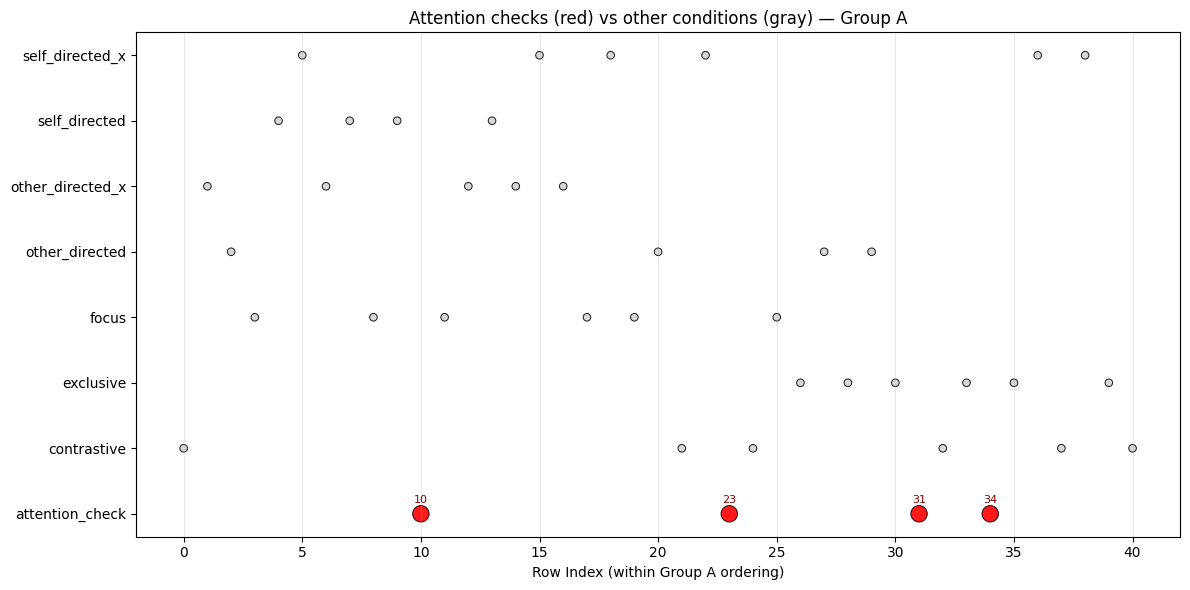

In [14]:
# Visualize for me that in group a, where are the attention checks in the row order compared to other conditions
import matplotlib.pyplot as plt
import numpy as np

# Normalize condition strings to avoid mismatches (strip, lower, replace spaces/hyphens with underscore)
df_a = df_a.copy()
df_a['condition_norm'] = (
    df_a['condition'].astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r'[\s-]+', '_', regex=True)
)

# Debug: show unique normalized conditions so we can see why an exact match may have failed
print("Unique conditions (normalized):", sorted(df_a['condition_norm'].unique()))

plt.figure(figsize=(12, 6))
# Convert normalized condition to categorical codes so we can plot on a numeric y-axis with meaningful labels
conds = pd.Categorical(df_a['condition_norm'])
y_vals = conds.codes

# styles: attention checks stand out (big red markers with black edge); others are small light-gray markers
is_ac = df_a['condition_norm'] == 'attention_check'
colors = np.where(is_ac, 'red', 'lightgray')
sizes = np.where(is_ac, 140, 30)
edgecolors = np.where(is_ac, 'black', 'none')

plt.scatter(df_a.index, y_vals, c=colors, s=sizes, alpha=0.9, edgecolors=edgecolors, linewidths=0.7)

# Annotate attention checks with their row index for quick identification
ac_indices = df_a.index[is_ac]
for idx in ac_indices:
    pos = df_a.index.get_loc(idx)
    plt.annotate(str(idx), (idx, y_vals[pos]), xytext=(0, 8), textcoords='offset points', ha='center', fontsize=8, color='darkred')

# Y ticks show the condition names
plt.yticks(np.arange(len(conds.categories)), conds.categories)
plt.xlabel('Row Index (within Group A ordering)')
plt.title('Attention checks (red) vs other conditions (gray) — Group A')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("attention_checks_group_a.png")
plt.show()

Unique conditions (normalized): ['attention_check', 'contrastive', 'exclusive', 'focus', 'other_directed', 'other_directed_x', 'self_directed', 'self_directed_x']


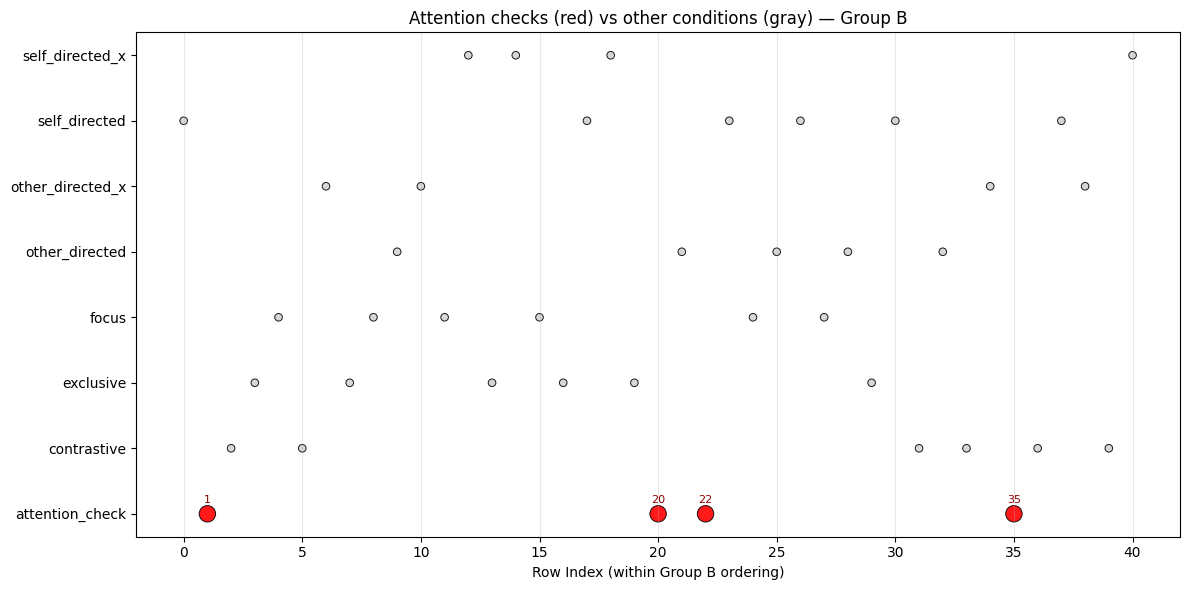

In [15]:
# Visualize for me that in group a, where are the attention checks in the row order compared to other conditions
import matplotlib.pyplot as plt
import numpy as np

# Normalize condition strings to avoid mismatches (strip, lower, replace spaces/hyphens with underscore)
df_b = df_b.copy()
df_b['condition_norm'] = (
    df_b['condition'].astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r'[\s-]+', '_', regex=True)
)

# Debug: show unique normalized conditions so we can see why an exact match may have failed
print("Unique conditions (normalized):", sorted(df_b['condition_norm'].unique()))

plt.figure(figsize=(12, 6))
# Convert normalized condition to categorical codes so we can plot on a numeric y-axis with meaningful labels
conds = pd.Categorical(df_b['condition_norm'])
y_vals = conds.codes

# styles: attention checks stand out (big red markers with black edge); others are small light-gray markers
is_ac = df_b['condition_norm'] == 'attention_check'
colors = np.where(is_ac, 'red', 'lightgray')
sizes = np.where(is_ac, 140, 30)
edgecolors = np.where(is_ac, 'black', 'none')

plt.scatter(df_b.index, y_vals, c=colors, s=sizes, alpha=0.9, edgecolors=edgecolors, linewidths=0.7)

# Annotate attention checks with their row index for quick identification
ac_indices = df_b.index[is_ac]
for idx in ac_indices:
    pos = df_b.index.get_loc(idx)
    plt.annotate(str(idx), (idx, y_vals[pos]), xytext=(0, 8), textcoords='offset points', ha='center', fontsize=8, color='darkred')

# Y ticks show the condition names
plt.yticks(np.arange(len(conds.categories)), conds.categories)
plt.xlabel('Row Index (within Group B ordering)')
plt.title('Attention checks (red) vs other conditions (gray) — Group B')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("attention_checks_group_b.png")
plt.show()



Unique conditions (normalized): ['attention_check', 'contrastive', 'exclusive', 'focus', 'other_directed', 'other_directed_x', 'self_directed', 'self_directed_x']


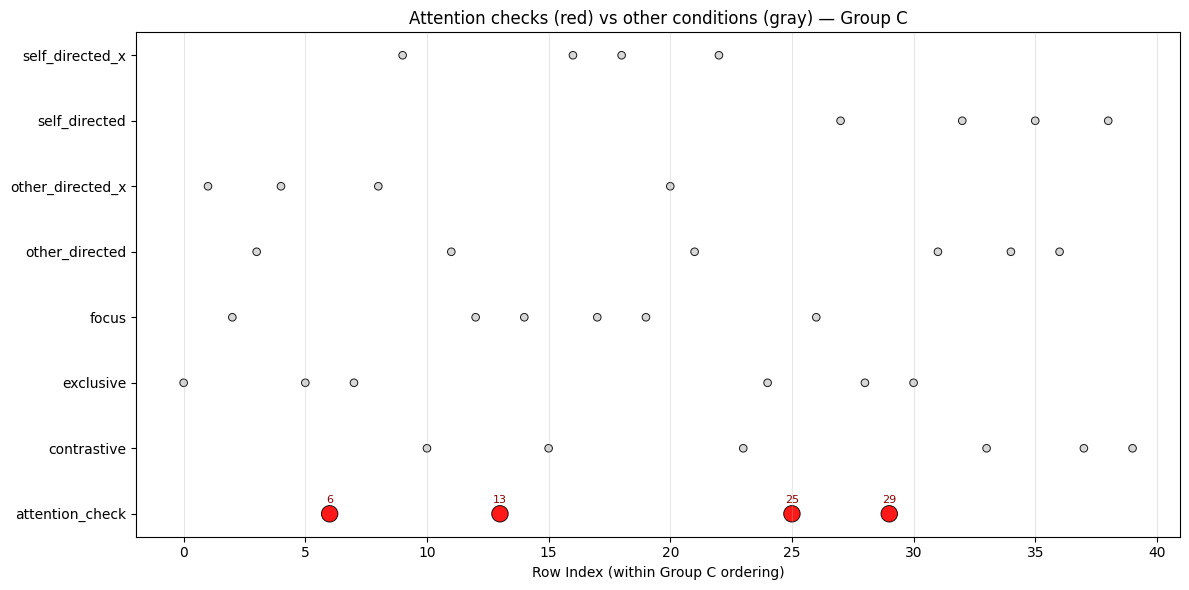

In [16]:
# Visualize for me that in group a, where are the attention checks in the row order compared to other conditions
import matplotlib.pyplot as plt
import numpy as np

# Normalize condition strings to avoid mismatches (strip, lower, replace spaces/hyphens with underscore)
df_c = df_c.copy()
df_c['condition_norm'] = (
    df_c['condition'].astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r'[\s-]+', '_', regex=True)
)

# Debug: show unique normalized conditions so we can see why an exact match may have failed
print("Unique conditions (normalized):", sorted(df_c['condition_norm'].unique()))

plt.figure(figsize=(12, 6))
# Convert normalized condition to categorical codes so we can plot on a numeric y-axis with meaningful labels
conds = pd.Categorical(df_c['condition_norm'])
y_vals = conds.codes

# styles: attention checks stand out (big red markers with black edge); others are small light-gray markers
is_ac = df_c['condition_norm'] == 'attention_check'
colors = np.where(is_ac, 'red', 'lightgray')
sizes = np.where(is_ac, 140, 30)
edgecolors = np.where(is_ac, 'black', 'none')

plt.scatter(df_c.index, y_vals, c=colors, s=sizes, alpha=0.9, edgecolors=edgecolors, linewidths=0.7)

# Annotate attention checks with their row index for quick identification
ac_indices = df_c.index[is_ac]
for idx in ac_indices:
    pos = df_c.index.get_loc(idx)
    plt.annotate(str(idx), (idx, y_vals[pos]), xytext=(0, 8), textcoords='offset points', ha='center', fontsize=8, color='darkred')

# Y ticks show the condition names
plt.yticks(np.arange(len(conds.categories)), conds.categories)
plt.xlabel('Row Index (within Group C ordering)')
plt.title('Attention checks (red) vs other conditions (gray) — Group C')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("attention_checks_group_c.png")
plt.show()